In [1]:
from data_preprocessing import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgb

from sklearn.cluster import AgglomerativeClustering
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from sklearn import tree
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, set_link_color_palette

# ignore FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# plotting settings
sns.set_style("ticks", rc={"font.size": 11})
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.size": 11})

# 2. Narrowing Down the Search

### 2.1 Clustering Methane Output

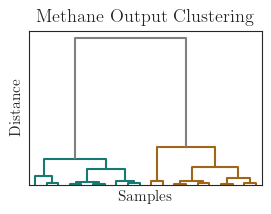

In [2]:
z = linkage(df_CH4DMI,'ward')

sns.set_style("ticks", rc={"font.size": 11})
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.size": 11})
fig, ax = plt.subplots(1, figsize=(3,2))

set_link_color_palette([sns.color_palette("BrBG", 6).as_hex()[5], sns.color_palette("BrBG", 6).as_hex()[0]])
dn = dendrogram(z,no_labels=True, above_threshold_color='grey')

ax.set_title('Methane Output Clustering')
plt.ylabel('Distance')
plt.xlabel('Samples')
plt.yticks([], [])
plt.show()

In [3]:
# write sample-to-cluster mapping to file
clusters = fcluster(z, 5, criterion='distance')
clusters = np.array(['', 'high', 'low'])[clusters]
# df_clusters = pd.DataFrame(np.column_stack((df_CH4DMI.index, clusters)), columns=['Metatranscriptome ID', 'Cluster'])
# df_clusters.to_csv('Data/clustering_based_clusters.csv', index=False)

### 2.2 Distinguishing low and high methane output using ML

In [4]:
# join clusters to data
data = df_cpm.join(df_clusters, how='inner')

#### There are multiple contigs that can distinguish perfectly between low and high methane!

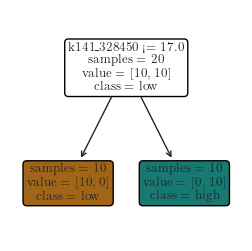

In [5]:
# plot
plt.figure(figsize=(3, 3))
colors = [sns.color_palette("BrBG", 6).as_hex()[0], sns.color_palette("BrBG", 6).as_hex()[5]]

dtree = tree.DecisionTreeClassifier()
X, y = data.to_numpy()[:,:-1], data.to_numpy()[:,-1]
dtree.fit(X, y)

artists = tree.plot_tree(dtree,filled=True, feature_names=list(df_cpm.columns[:-1]), class_names=list(data['Cluster'].unique()),
                         impurity=False, rounded=True)

for artist, impurity, value in zip(artists, dtree.tree_.impurity, dtree.tree_.value):
    # let the max value decide the color; whiten the color depending on impurity (gini)
    r, g, b = to_rgb(colors[np.argmax(value)])
    f = impurity * 2 # for N colors: f = impurity * N/(N-1) if N>1 else 0
    artist.get_bbox_patch().set_facecolor((f + (1-f)*r, f + (1-f)*g, f + (1-f)*b))
    artist.get_bbox_patch().set_edgecolor('black')

plt.show()

#### Count these contigs

In [6]:
# features = list(data.columns)
# stump_features = []
# last_tree_depth = 1
# while last_tree_depth < 2:
#     dtree = tree.DecisionTreeClassifier()
#     X, y = data[features].to_numpy()[:,:-1], data[features].to_numpy()[:,-1]
#     dtree.fit(X, y)
#     if (dtree.tree_.max_depth == 1):
#         ft1 = features[dtree.tree_.feature[0]]
#         stump_features.append(ft1)
#         features.remove(ft1)
#     else:
#         last_tree_depth = dtree.tree_.max_depth

In [7]:
# file = open('Results/stump_features.txt','w')
# for item in stump_features:
#     file.write(item+"\n")
# file.close()

In [8]:
len(list(pd.read_csv('Results/stump_features.txt', header=None)[0]))

348

We found 348 contigs that can perfectly distinguish between high and low methane outputs!

### 2.3 Finding statistically significant differences in contig distributions among classes

Inspired by the above findings, we question if these contigs distinguishing between high and low methane outputs are luck-based or actually statistically significant findings. We run pairwise t-tests for each contig between the corresponding contig counts of samples with high methane output and samples with low methane output.

In [9]:
# # Pairwise T-Tests
# #    T-statistic: difference between the sample means divided by the standard error of the difference.
# #    P-value: probability of observing the data (or more extreme data) assuming that there is NO significant 
# #       difference between the two groups.
# #       small p-value => observed difference between the groups is unlikely to have occurred by chance alone.

# # Separate data into two DataFrames based on class labels
# class_0_data = data[data['Cluster'] == 'low']
# class_1_data = data[data['Cluster'] == 'high']

# # Initialize an empty DataFrame to store the p-values
# res = []

# # Iterate through columns
# for column in data.columns[:-1]:
    
#     t_stat, p_value = ttest_ind(class_0_data[column], class_1_data[column])
    
#     # Append the results to the p_values_df
#     res.append([column, t_stat, p_value])

# # Print or analyze the p-values to determine significance
# p_values_df = pd.DataFrame(res, columns=['Contig', 't-statistic', 'p-value'])
# p_values_df.to_csv('Data/t-test_differences_per_contig_between_classes.csv', index=False)

In [11]:
p_values_df = pd.read_csv('Data/t-test_differences_per_contig_between_classes.csv')
p_values_df_sorted = p_values_df.sort_values(by=['p-value'], ascending=False)

In [12]:
# prepare plot
counts = []
pvals = p_values_df_sorted['p-value']
for val in [0.001, 0.0001, 0.00001, 0.000001]:
    counts.append(['p-value $<$ '+str(val), np.sum(pvals < val)])
df_counts = pd.DataFrame(counts, columns=['a', 'Contig Count'])

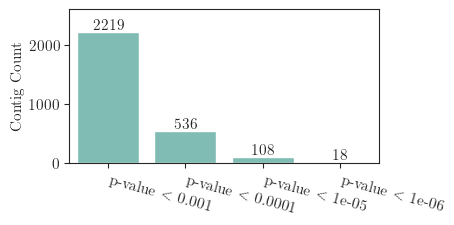

In [13]:
# plot
fig, ax = plt.subplots(1, figsize=(4,2))
sns.barplot(df_counts, x='a', y='Contig Count', ax=ax, color=sns.color_palette("BrBG", 6)[4])
ax.set_xticklabels(ax.get_xticklabels(), rotation=345, horizontalalignment='left')
ax.set_xlabel('')
ax.set_ylabel('Contig Count')
ax.bar_label(ax.containers[0])
ax.set_ylim([0, 2600])

plt.show()